In [ ]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import (
    Input, Add, Dense, Activation, ZeroPadding2D, Flatten,
    Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import random_uniform

## SOURCES USED: 
# CS230 "Residual Networks" Programming Assignment 
# Debugging assistance with ChatGPT 

Basic CNN 

Import tsvs

In [5]:
# import data files 
base_path = "place-pulse-2.0"

# Load TSVs
qscores = pd.read_csv(os.path.join(base_path, "qscores.tsv"), sep='\t')
locations = pd.read_csv(os.path.join(base_path, "locations.tsv"), sep='\t')
places = pd.read_csv(os.path.join(base_path, "places.tsv"), sep='\t')

# Merge data files, compile into one dataset with just images + scores
merged = qscores.merge(locations, left_on="location_id", right_on="_id", suffixes=("_score", "_loc"))
merged = merged.merge(places, left_on="place_id_loc", right_on="_id", suffixes=("", "_place"))

# build image files from components 
def build_image_filename(row):
    lat = row['loc.0']
    lon = row['loc.1']
    loc_id = row['_id_loc']
    city = row['place_name']
    return f"{lat}_{lon}_{loc_id}_{city}.jpg"

merged["filename"] = merged.apply(build_image_filename, axis=1)
merged["filepath"] = merged["filename"].apply(lambda x: os.path.join(base_path, "images", x))

# output just image file name and trueskill score 
merged[["filepath", "trueskill.score"]].head()

,filepath,trueskill.score
0,place-pulse-2.0/images/45.571711_-73.550288000...,36.502702
1,place-pulse-2.0/images/41.747151_-87.735997_51...,32.762342
2,place-pulse-2.0/images/48.927194_2.26731100000...,26.115423
3,place-pulse-2.0/images/-22.928259_-43.25587300...,17.800618
4,place-pulse-2.0/images/45.50755_-73.5351540000...,12.561016


In [6]:
merged = merged[merged["filepath"].apply(os.path.exists)]

image_df = merged[["filepath", "trueskill.score"]]


In [ ]:
# Test loading sample image
i = 10

sample_path = image_df["filepath"].iloc[i]
img = mpimg.imread(sample_path)
plt.imshow(img)
plt.title(f"Score: {image_df['trueskill.score'].iloc[i]:.2f}")
plt.show()


In [ ]:
# FIRST PASS AT MODEL 

# data split 
train_df, test_df = train_test_split(image_df, test_size=0.2, random_state=42)

IMG_SIZE = (224, 224)

def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # normalize to [0, 1]
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_df["filepath"].values, train_df["trueskill.score"].values))
test_ds = tf.data.Dataset.from_tensor_slices((test_df["filepath"].values, test_df["trueskill.score"].values))

train_ds = train_ds.map(preprocess).batch(32).shuffle(500)
test_ds = test_ds.map(preprocess).batch(32)

# basic CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)  # regression → no activation
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()



In [ ]:
# train model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

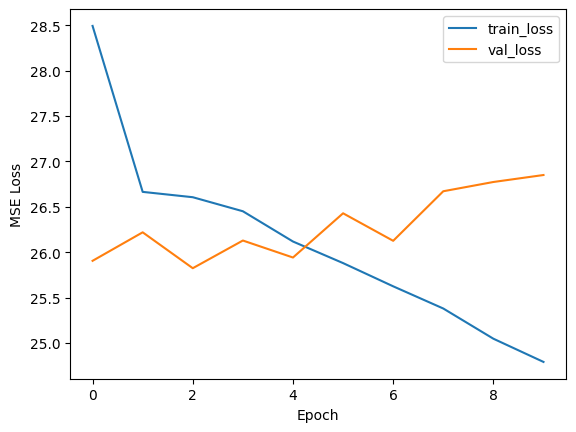

In [ ]:
# plot training vs validation loss 
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


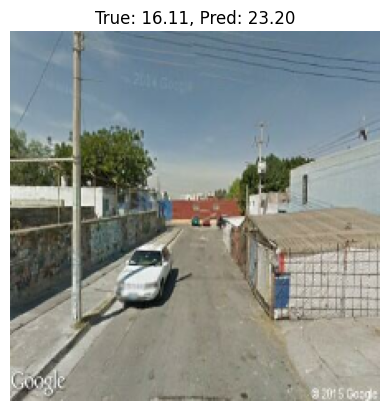

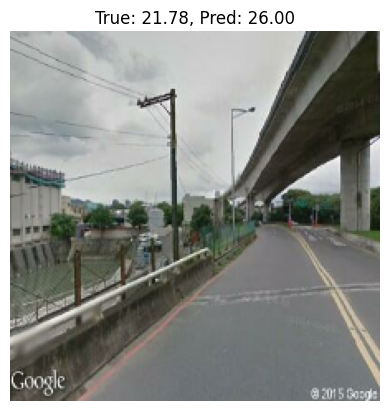

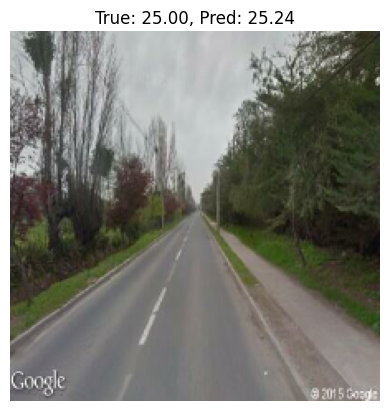

2025-11-11 00:19:08.953761: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# run a few tests 
for imgs, labels in test_ds.take(1):
    preds = model.predict(imgs)
    for i in range(3):  # show first 3 images
        plt.imshow(imgs[i])
        plt.title(f"True: {labels[i]:.2f}, Pred: {preds[i][0]:.2f}")
        plt.axis('off')
        plt.show()


Model v. 2 - ResNet

In [12]:
# identity block helper function 
def identity_block(X, f, filters, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    ## Set the padding = 'same'
    X = Conv2D(filters=F2, kernel_size=f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    ## Set the padding = 'valid'
    X = Conv2D(filters=F3, strides = (1,1), kernel_size = 1, padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X

In [13]:
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X) 
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X) 
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size = 1, strides = (s,s), padding = 'valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    

In [14]:
def ResNet50_regression(input_shape=(224, 224, 3)):
    """
    ResNet50 architecture using helper functions we learned in CS230,
    modified for regression output instead of classification.
    """
    X_input = tf.keras.Input(input_shape)
    X = layers.ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = layers.Conv2D(64, (7,7), strides=(2,2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3,3), strides=(2,2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64,64,256], s=1)
    X = identity_block(X, 3, [64,64,256])
    X = identity_block(X, 3, [64,64,256])

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128,128,512], s=2)
    for _ in range(3):
        X = identity_block(X, 3, [128,128,512])

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256,256,1024], s=2)
    for _ in range(5):
        X = identity_block(X, 3, [256,256,1024])

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512,512,2048], s=2)
    X = identity_block(X, 3, [512,512,2048])
    X = identity_block(X, 3, [512,512,2048])

    # Average Pooling and Regression Output
    X = layers.AveragePooling2D((2,2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(1, activation='linear', kernel_initializer=glorot_uniform(seed=0))(X)

    model = tf.keras.Model(inputs=X_input, outputs=X)
    return model


# Build and compile model
model = ResNet50_regression(input_shape=(*IMG_SIZE, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='mse',
              metrics=['mae'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 55,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 55, 55,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 55, 55,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 55, 55,    │          0 │ batch_normalizat

 Total params: 23,606,145 (90.05 MB)

 Trainable params: 23,553,025 (89.85 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
# ResNet
def ResNet50(input_shape = (64, 64, 3), classes = 6, training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    # Use the instructions above in order to implement all of the Stages below
    # Make sure you don't miss adding any required parameter
    
    ## Stage 3 (≈4 lines)
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    
    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f=3, filters = [256, 256, 1024], s=2)
    
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f=3, filters = [512, 512, 2048], s=2)
    
    # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D()(X)"
    X = AveragePooling2D((2, 2))(X)
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [17]:
train_df, test_df = train_test_split(image_df, test_size=0.2, random_state=42)

IMG_SIZE = (224, 224)
BATCH_SIZE = 8

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_df['filepath'], train_df['trueskill.score']))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['filepath'], test_df['trueskill.score']))

train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.batch(BATCH_SIZE).cache().shuffle(500).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


In [8]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/10


2025-11-12 19:45:36.586586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


8110/8110 ━━━━━━━━━━━━━━━━━━━━ 616s 75ms/step - loss: 42.1801 - mae: 4.9955 - val_loss: 26.8853 - val_mae: 4.1460
Epoch 2/10
8110/8110 ━━━━━━━━━━━━━━━━━━━━ 731s 90ms/step - loss: 31.2872 - mae: 4.4909 - val_loss: 26.0692 - val_mae: 4.0749
Epoch 3/10
8110/8110 ━━━━━━━━━━━━━━━━━━━━ 770s 95ms/step - loss: 29.9582 - mae: 4.3929 - val_loss: 26.0454 - val_mae: 4.0707
Epoch 4/10
8110/8110 ━━━━━━━━━━━━━━━━━━━━ 742s 91ms/step - loss: 29.2992 - mae: 4.3429 - val_loss: 26.0126 - val_mae: 4.0690
Epoch 5/10
8110/8110 ━━━━━━━━━━━━━━━━━━━━ 749s 92ms/step - loss: 28.9588 - mae: 4.3180 - val_loss: 26.2049 - val_mae: 4.0839
Epoch 6/10
8110/8110 ━━━━━━━━━━━━━━━━━━━━ 739s 91ms/step - loss: 28.6942 - mae: 4.2997 - val_loss: 26.0087 - val_mae: 4.0734
Epoch 7/10
8110/8110 ━━━━━━━━━━━━━━━━━━━━ 731s 90ms/step - loss: 28.6078 - mae: 4.2933 - val_loss: 26.0289 - val_mae: 4.0695
Epoch 8/10
8110/8110 ━━━━━━━━━━━━━━━━━━━━ 776s 96ms/step - loss: 28.4819 - mae: 4.2807 - val_loss: 25.9762 - val_mae: 4.0706
Epoch 9/10


2028/2028 ━━━━━━━━━━━━━━━━━━━━ 125s 62ms/step - loss: 25.9421 - mae: 4.0659
Test MAE: 4.066


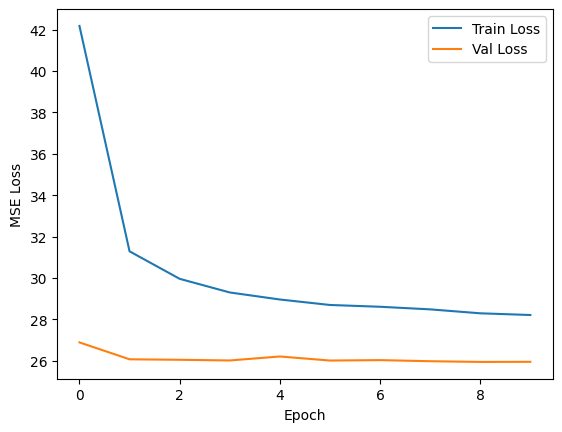

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


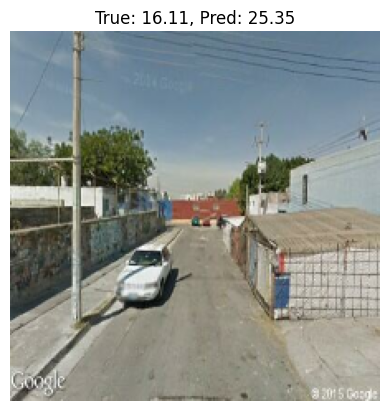

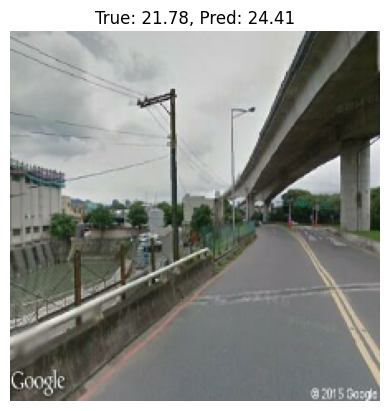

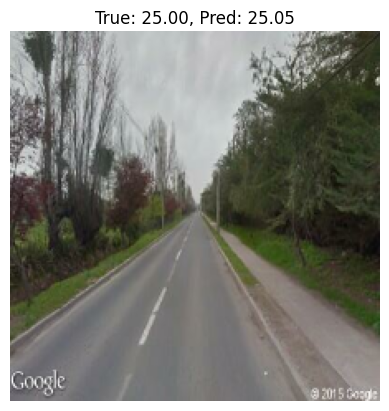

2025-11-12 21:59:20.638662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate performance
test_loss, test_mae = model.evaluate(test_ds)
print(f"Test MAE: {test_mae:.3f}")

# Plot loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Check sample predictions
for imgs, labels in test_ds.take(1):
    preds = model.predict(imgs)
    for i in range(3):
        plt.imshow(imgs[i])
        plt.title(f"True: {labels[i]:.2f}, Pred: {preds[i][0]:.2f}")
        plt.axis('off')
        plt.show()
